In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv


# **📌 Step 1: Understanding the Problem**

**The Story Begins…
Imagine you are a data scientist at a financial company. Your job? Detect fraudulent transactions and prevent financial losses. Every day, thousands of transactions occur, and some are fraudulent—but catching them is like finding a needle in a haystack.**

*You have been given a dataset, generated using PaySim, which simulates mobile money transactions. Your mission is to build a machine learning model that can predict fraud before it happens.*

# **📌 Step 2: Importing the Necessary Libraries**

# **📌 Step 3: Loading the Dataset**

In [2]:
# Basic libraries for data manipulation
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Ignore warnings for better readability
import warnings
warnings.filterwarnings('ignore')

# Set a visual style
sns.set_style("whitegrid")

file_path = "/kaggle/input/paysim1/PS_20174392719_1491204439457_log.csv"
df = pd.read_csv(file_path)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# **📌 Step 4: Exploring the Data**

In [3]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# **📌 Step 5: Understanding Fraudulent Transactions**

> Finding the Needle in the Haystack

> Now, let’s check how many transactions are fraudulent.

isFraud
0    6354407
1       8213
Name: count, dtype: int64


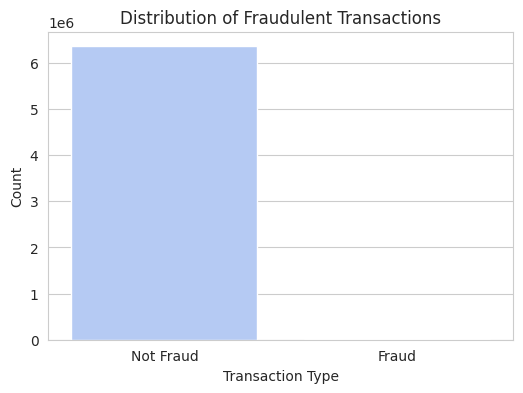

In [4]:
# Count fraud vs. non-fraud transactions
fraud_counts = df['isFraud'].value_counts()
print(fraud_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values, palette="coolwarm")
plt.xticks([0, 1], ["Not Fraud", "Fraud"])
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.title("Distribution of Fraudulent Transactions")
plt.show()

*🔹 Wow! Fraudulent transactions are extremely rare. This is a common challenge in fraud detection—our data is imbalanced, meaning we need special techniques to train our model properly.*

# **📌 Step 6: Understanding Transaction Types**

> ***Which Transaction Types Are Risky?***

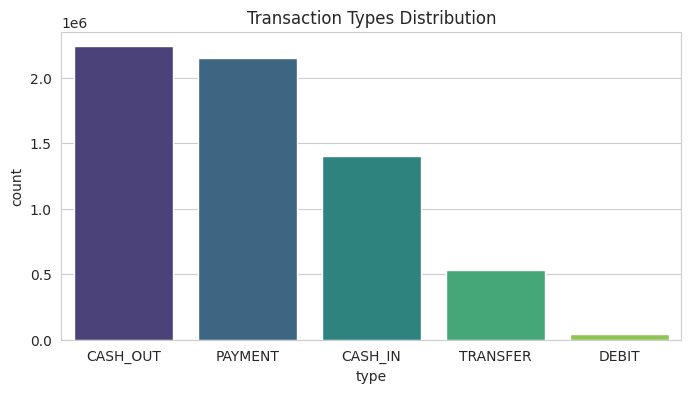

In [5]:
# Count transaction types
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="type", palette="viridis", order=df["type"].value_counts().index)
plt.title("Transaction Types Distribution")
plt.show()

> *🔹 It looks like most transactions are PAYMENT, CASH-OUT, CASH_IN type and TRANSFER. But which ones are most fraud prone?*

In [6]:
# Fraud percentage per transaction type
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending=False)
print(fraud_by_type)

type
TRANSFER    0.007688
CASH_OUT    0.001840
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64


> *🔹 Interesting. The TRANSFER and CASH-OUT transactions have the highest fraud rates. This makes sense fraudsters often transfer money to another account and cash it out.*

# **📌 Step 7: Data Preprocessing**

***Preparing the Data for Machine Learning***

***Before we train our model, we need to clean and prepare the dataset.***

> 1️⃣ Removing Unnecessary Columns

In [7]:
df = df.drop(['nameOrig', 'nameDest'], axis=1)

> 2️⃣ Encoding Categorical Features

In [8]:
# Convert 'type' to numerical values using Label Encoding
encoder = LabelEncoder()
df["type"] = encoder.fit_transform(df["type"])

> 3️⃣ Handling Class Imbalance

*Because fraud cases are rare, we need to handle data imbalance.*

In [9]:
# Downsample majority class (non-fraud transactions) to match the minority class
fraud = df[df["isFraud"] == 1]
non_fraud = df[df["isFraud"] == 0].sample(n=len(fraud), random_state=42)

# Combine fraud and non-fraud samples
balanced_df = pd.concat([fraud, non_fraud])

# Shuffle dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# **📌 Step 8: Splitting Data for Training & Testing**

> **spliting the dataset into a training set (80%) and a test set (20%).**

In [10]:
X = balanced_df.drop("isFraud", axis=1)
y = balanced_df["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **📌 Step 9: Training a Machine Learning Model**

> ***The Fraud Detector in Action***

In [11]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# **📌 Step 10: Evaluating the Model**

***1️⃣ Classification Report, Did we catch the fraudsters?***

In [12]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9930006086427268
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      1622
           1       0.99      1.00      0.99      1664

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



> Look at the Precision and Recall for fraud cases (1s).

* High Precision (close to 1) → Model makes fewer false fraud alerts.
* High Recall (close to 1) → Model catches more actual fraud cases.
* F1-score balances both!

***2️⃣ Confusion Matrix: How Many Frauds Are Caught?***

* true positives (correct fraud cases detected).
* false negatives (missed frauds).

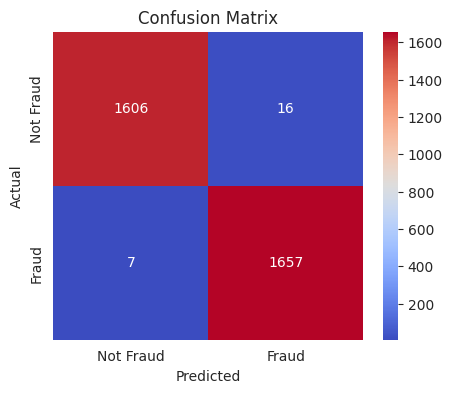

In [13]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

> * False Negatives (Bottom-Left Box): Actual fraud but predicted as non-fraud.
> * False Positives (Top-Right Box): Model flags legit transactions as fraud.

***3️⃣ Adjusting the Threshold for Better Fraud Detection***

In [14]:
y_probs = model.predict_proba(X_test)[:, 1]  # Probabilities of being fraud
threshold = 0.3
y_pred_new = (y_probs > threshold).astype(int)
print(classification_report(y_test, y_pred_new))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1622
           1       0.98      1.00      0.99      1664

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



> *🔹 Lowering the threshold means catching more fraud cases (higher recall), but it might increase false alarms.*

# **📌 Step 11: Trying XGBoost for Better Performance**

> *XGBoost is faster, handles imbalanced data well, and often outperforms Random Forest in fraud detection.*

In [15]:
import xgboost as xgb
from sklearn.metrics import classification_report
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1622
           1       0.99      1.00      1.00      1664

    accuracy                           1.00      3286
   macro avg       1.00      1.00      1.00      3286
weighted avg       1.00      1.00      1.00      3286



> ***If the model gets 100% accuracy on training data, it might just be memorizing the dataset.
Let's compare training vs. test accuracy:***

**🔍 Step 1: Check for Overfitting**

In [16]:
train_acc = xgb_model.score(X_train, y_train)
test_acc = xgb_model.score(X_test, y_test)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Training Accuracy: 0.9999
Test Accuracy: 0.9957


* ✅ If training and test accuracy are close → No overfitting!
* ⚠️ If training accuracy is 100% but test accuracy drops → Model is overfitting

***🔍 Step 2: Check Precision & Recall***

*A fraud detection model is not just about accuracy!*

*Precision & Recall tell us if the model really detects fraud correctly.*

In [17]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1622
           1       0.99      1.00      1.00      1664

    accuracy                           1.00      3286
   macro avg       1.00      1.00      1.00      3286
weighted avg       1.00      1.00      1.00      3286



> Precision: Out of the detected fraud cases, how many are actually fraud?

> Recall: Out of all actual fraud cases, how many did the model detect?

* ✅ Ideal Model: High precision & recall (not just accuracy).
* ⚠️ If Precision is high but Recall is low → Model is missing fraud cases!

***🔍 Step 3: Cross-Validation for More Reliable Results***

*Instead of testing once, i'll split the dataset multiple times and train the model on different parts.
This will confirm if the model is really robust.*

In [18]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

print(f"Cross-validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}") 

Cross-validation Accuracy Scores: [0.99300061 0.99452055 0.9957382  0.99452055 0.99238965]
Mean Accuracy: 0.9940


> ✅ If accuracy is consistent across all splits → Model is reliable!

> ⚠️ If accuracy varies a lot → Model might not generalize well.

***🔍 Step 4: Look at Feature Importance***

> XGBoost lets us see which features are most important for detecting fraud.

* ✅ If expected fraud-related features are important (e.g., transaction amount) → Good!
  
* ⚠️ If unimportant features are at the top → Model might be learning something weird.

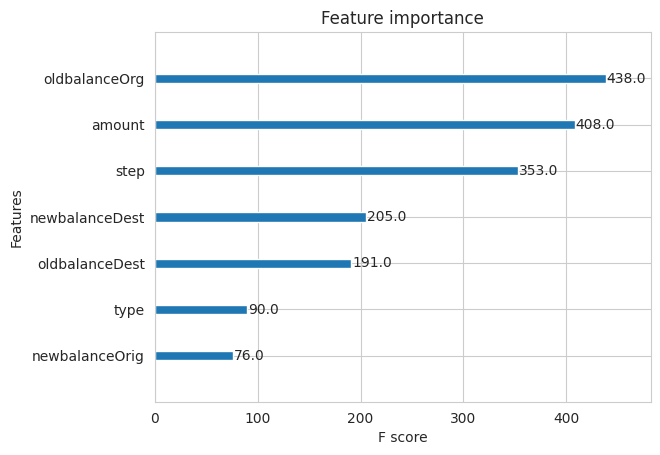

In [19]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

In [20]:
y_pred = xgb_model.predict(X_test)
results_df = X_test.copy()
results_df['Predicted_Fraud'] = y_pred
results_df['Actual_Fraud'] = y_test.values  
results_df.to_csv("/kaggle/working/fraud_predictions.csv", index=False)
print("✅ Predictions saved as fraud_predictions.csv")

✅ Predictions saved as fraud_predictions.csv
